# DOGS: Data Modelling #

### Imports ###

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

### Data Preview ###
Dog data was extracted from the data exported from the Champ_DOG_Transformation notebook.

In [71]:
dtd = pd.read_csv('dog_transformed_data.csv', index_col=0)

In [72]:
print("Total entries: ", len(dtd))
dtd.head()

Total entries:  52240


,Gender_LITTER,Gender_MALE,Gender_UNKNOWN,IntakeInternalStatus_AGG ANIMAL,IntakeInternalStatus_AGG BARRIE,IntakeInternalStatus_AGG FEAR,IntakeInternalStatus_AGG FOOD,IntakeInternalStatus_AGG PEOPLE,IntakeInternalStatus_AGGRESSIVE,IntakeInternalStatus_DEHYDRA,...,Breed_OTHER-LARGE,Breed_OTHER-MEDIUM,Breed_OTHER-SMALL,Breed_PIT BULL,Breed_POMERANIAN,Breed_POODLE - MINIATURE,Breed_PUG,Breed_ROTTWEILER,Breed_SHIH TZU,Breed_TERRIER-SMALL
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Creating Train, Validation, and Test Sets ###
The train, validation, test split was 60/20/20.

In [73]:
X = dtd.drop('LiveOutcome_1', axis = 1)
y = dtd['LiveOutcome_1']

In [74]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

### Using SVM Model as a Baseline ###

In [6]:
svm_clf = svm.SVC()
svm_clf.fit(X_trainval, y_trainval)
svm_clf.score(X_test, y_test)

C:\Users\phoenix.gaylor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8339395099540582

The SVM model, when trained on both the training and validation sets, obtained around 83% accuracy, which is an additional 22% over the guessing rate of 54% (all "lived"). This means using SVM results in 63% fewer misclassfications than guessing.

### Training a (Shallow) Neural Network ###

#### Converting outcomes to a format interpretable by Keras ####

In [75]:
y_trainval = to_categorical(y_trainval)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#### Developing function that trains and evaluates a Keras model ####

In [76]:
def test_model(d, u, ud, l = 0.2, e = 25, b = 62):
    
    """Given the required parameters, builds a Keras model, fits it to the X_train and y_train sets, 
    and evaluates the model according to the validation set.
    
    Inputs:
        d  - Dropout Rate
        u  - Units in 1st layer
        ud - Units in 2nd layer as the division of u/ud 
        l  - Learning Rate (default: 0.2)
        e  - Number of epochs (default: 25)
        b  - Batch size (default: 62)
        
    Outputs:
        result - An array with the given d, u, ud, and model accuracy on the validation set"""
    
    model = Sequential()

    model.add(Dense(units=u, 
                    activation='relu', 
                    kernel_initializer=keras.initializers.he_normal(seed=1),
                    input_dim=len(X_train.columns)))
    model.add(Dropout(d))
    model.add(Dense(units=int(u/ud), activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(units=2, activation='softmax'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=l),
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=e, batch_size=b, verbose=0)
    print("Validation: ", model.evaluate(X_val, y_val))
    result = [d, u, ud, model.evaluate(X_val, y_val)[1]]

    return result

#### Developing a function that loops through different parameters to determine optimal combination ####

In [78]:
def best_models(d_vals, u_vals, ud_vals, l = 0.2, e = 25, b = 62):
        
    """Loops through each combination of dropout rates and units per layer and runs them through test_model().
    
    Inputs:
        d_vals  - Dropout Rate values
        u_vals  - Units in 1st layer values
        ud_vals - Units in 2nd layer as the division of u/ud values
        l       - Learning Rate (default: 0.2)
        e       - Number of epochs (default: 25)
        b       - Batch size (default: 62)
        
    Outputs:
        result - An matrix with the given d_vals, u_vals, ud_vals, and their model accuracy on the validation set"""
    
    total_models = len(d_vals)*len(u_vals)*len(ud_vals)
    results = np.zeros((total_models,4))
    counter = 0
    
    for drate in d_vals:
        d = drate
    
        for units in u_vals:
            u = units
        
            for unitsd in ud_vals:
                ud = unitsd
                
                print("d =", drate, " u =", units, " ud =", unitsd, " counter =", counter)
                results[counter] = test_model(d = d, u = u, ud = ud)
                counter += 1
                
    return results

#### Running best_models() to find the best Keras models ####
Note: This takes a very long while to run.

In [79]:
d_vals = [0.1, 0.3, 0.5]
u_vals = [64, 128, 256, 512, 1024]
ud_vals = [1.5, 2, 2.5]

model_results = best_models(d_vals, u_vals, ud_vals)
model_results[model_results[:,3] > .855]

d = 0.1  u = 64  ud = 1.5  counter = 0
13060/13060 [==============================] - 0s 18us/step
Validation:  [0.369460258700216, 0.8406584858894348]
13060/13060 [==============================] - 0s 15us/step
d = 0.1  u = 64  ud = 2  counter = 1
13060/13060 [==============================] - 0s 17us/step
Validation:  [0.3775390100424359, 0.8392802476882935]
13060/13060 [==============================] - 0s 13us/step
d = 0.1  u = 64  ud = 2.5  counter = 2
13060/13060 [==============================] - 0s 19us/step
Validation:  [0.3771347987250201, 0.8392036557197571]
13060/13060 [==============================] - 0s 15us/step
d = 0.1  u = 128  ud = 1.5  counter = 3
13060/13060 [==============================] - 0s 17us/step
Validation:  [0.37970013321472895, 0.8384379744529724]
13060/13060 [==============================] - 0s 14us/step
d = 0.1  u = 128  ud = 2  counter = 4
13060/13060 [==============================] - 0s 31us/step
Validation:  [0.3860089719432419, 0.837595701217651

array([], shape=(0, 4), dtype=float64)

In [81]:
model_results[model_results[:,3] > .845]

array([[5.00000000e-01, 1.02400000e+03, 1.50000000e+00, 8.46324682e-01],
       [5.00000000e-01, 1.02400000e+03, 2.00000000e+00, 8.45482409e-01]])

The models that lead the pack are D=0.3, U=1024, U2=1.5 & 2.0, with approximately 84.5% accuracy.

#### Tuning the best model ####
Behind the scenes, I tried different combinations for learning rate, batch size, and number of epochs. It seems that a dropout of 0.3 typically results in severe overfitting and that the results above were by chance.

In [111]:
model = Sequential()

model.add(Dense(units=1024, 
                activation='relu', 
                kernel_initializer=keras.initializers.he_normal(seed=1),
                input_dim=len(X_train.columns)))
model.add(Dropout(0.5))
model.add(Dense(units=int(1024/2), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=0.1),
                metrics=['accuracy'])

history = model.fit(X_trainval, y_trainval, epochs=15, batch_size=60, verbose=1, validation_data = [X_test, y_test])
print("Test: ", model.evaluate(X_test, y_test))

Train on 41792 samples, validate on 10448 samples
Epoch 1/15
41792/41792 [==============================] - 6s 133us/step - loss: 0.4818 - accuracy: 0.7705 - val_loss: 0.4003 - val_accuracy: 0.8258
Epoch 2/15
41792/41792 [==============================] - 5s 126us/step - loss: 0.4247 - accuracy: 0.8090 - val_loss: 0.3905 - val_accuracy: 0.8299
Epoch 3/15
41792/41792 [==============================] - 5s 117us/step - loss: 0.4094 - accuracy: 0.8175 - val_loss: 0.3838 - val_accuracy: 0.8351
Epoch 4/15
41792/41792 [==============================] - 5s 116us/step - loss: 0.3994 - accuracy: 0.8231 - val_loss: 0.3808 - val_accuracy: 0.8360
Epoch 5/15
41792/41792 [==============================] - 5s 125us/step - loss: 0.3942 - accuracy: 0.8265 - val_loss: 0.3818 - val_accuracy: 0.8376
Epoch 6/15
41792/41792 [==============================] - 5s 117us/step - loss: 0.3873 - accuracy: 0.8326 - val_loss: 0.3791 - val_accuracy: 0.8358
Epoch 7/15
41792/41792 [==============================] - 6s 1

The model performs very well on the test set, just shy of 84% accuracy. This is about 1% better than the SVM model with 8% fewer misclassifications.

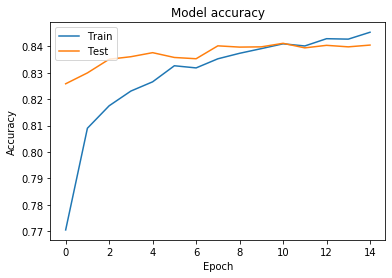

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The model tends to do pretty well and does not severely overfit.

### Saving the Model ###

In [113]:
model.save("dog_model.h5")